# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Содержание
<a href='#section1'> 2. Загрузка и подготовка данных </a> <br>
<a href='#section2'> 3. Обучение и проверка модели </a> <br>
<a href='#section3'> 4. Подготовка к расчёту прибыли </a> <br>
<a href='#section4'> 5. Расчёт прибыли и рисков </a> <br>
<a href='#section5'> 6. Общий вывод </a> <br>

In [1]:
!pip install phik -q
!pip install -Uq scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

<a id='section1'></a>
## Загрузка и подготовка данных

Данные геологоразведки трёх регионов находятся в файлах: <br>
/datasets/geo_data_0.csv. <br>
/datasets/geo_data_1.csv. <br>
/datasets/geo_data_2.csv. <br>
id — уникальный идентификатор скважины; <br>
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы); <br> 
product — объём запасов в скважине (тыс. баррелей).

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### geo_data_0

In [4]:
geo_data_0.info()
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [6]:
print(geo_data_0.duplicated().sum(), geo_data_0.drop('id', axis=1).duplicated().sum())

0 0


In [7]:
def plot_col(df, column):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.ylabel('Частота')
    plt.title(f'{column}')
    sns.histplot(df[column])
    plt.subplot(1, 2, 2)
    plt.title(f'{column}')
    sns.boxplot(x=df[column])

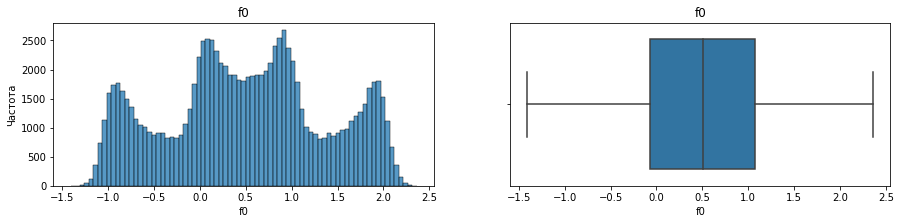

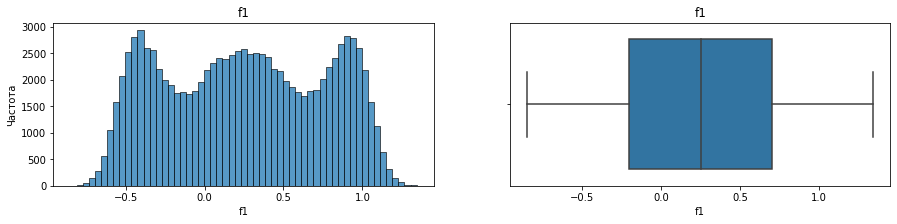

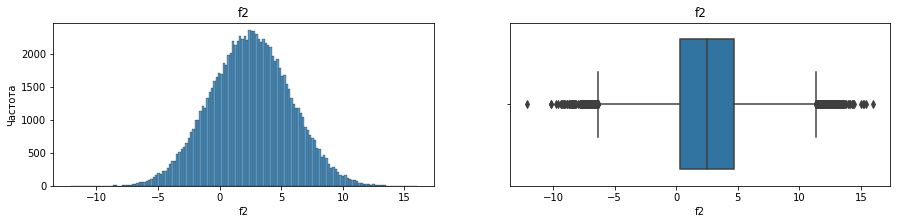

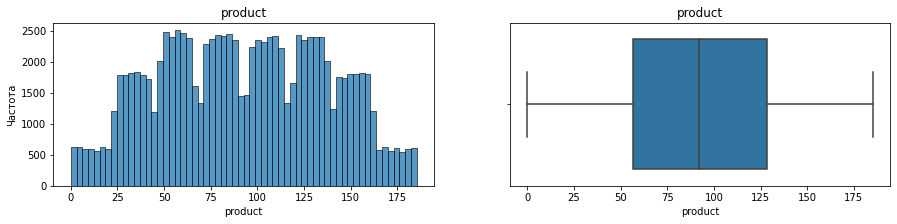

In [8]:
col_features = ['f0', 'f1', 'f2', 'product']
for col in col_features:
    plot_col(geo_data_0, col)

In [9]:
for i in col_features:
    stat, p_val = kstest(geo_data_0[i], "norm")
    if p_val < 0.05: 
        print(f'Распределение {i} не нормальное')
    else: 
        print(f'Распределение {i} нормальное')

Распределение f0 не нормальное
Распределение f1 не нормальное
Распределение f2 не нормальное
Распределение product не нормальное


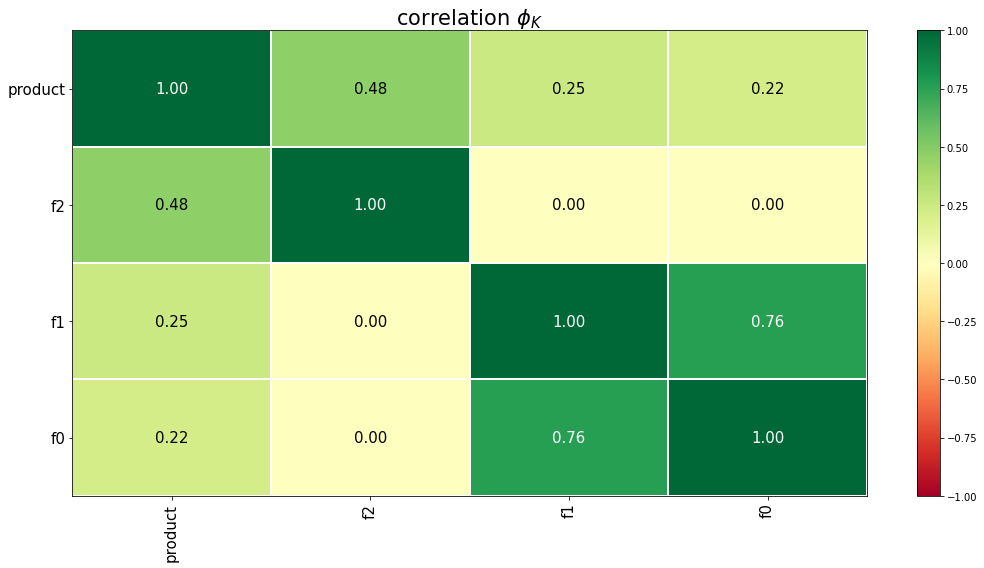

In [10]:
phik_overview = geo_data_0.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 8)
)

### geo_data_1

In [11]:
geo_data_1.info()
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [13]:
print(geo_data_1.duplicated().sum(), geo_data_1.drop('id', axis=1).duplicated().sum())

0 0


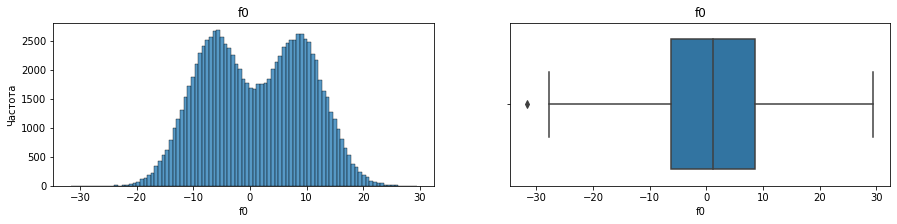

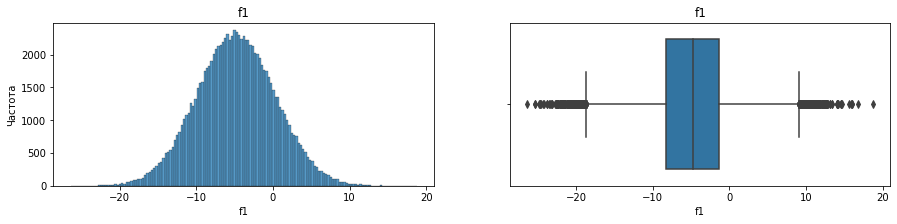

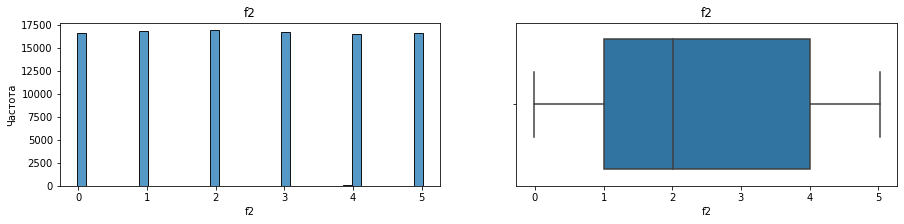

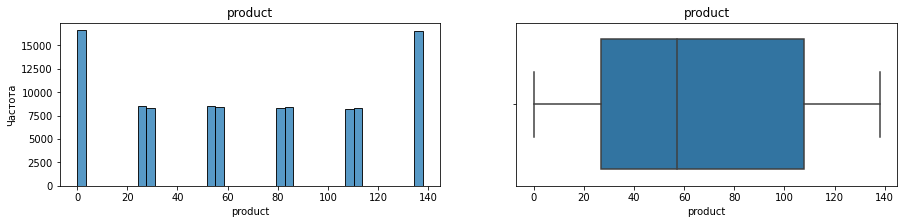

In [14]:
for col in col_features:
    plot_col(geo_data_1, col)

In [15]:
for i in col_features:
    stat, p_val = kstest(geo_data_1[i], "norm")
    if p_val < 0.05: 
        print(f'Распределение {i} не нормальное')
    else: 
        print(f'Распределение {i} нормальное')

Распределение f0 не нормальное
Распределение f1 не нормальное
Распределение f2 не нормальное
Распределение product не нормальное


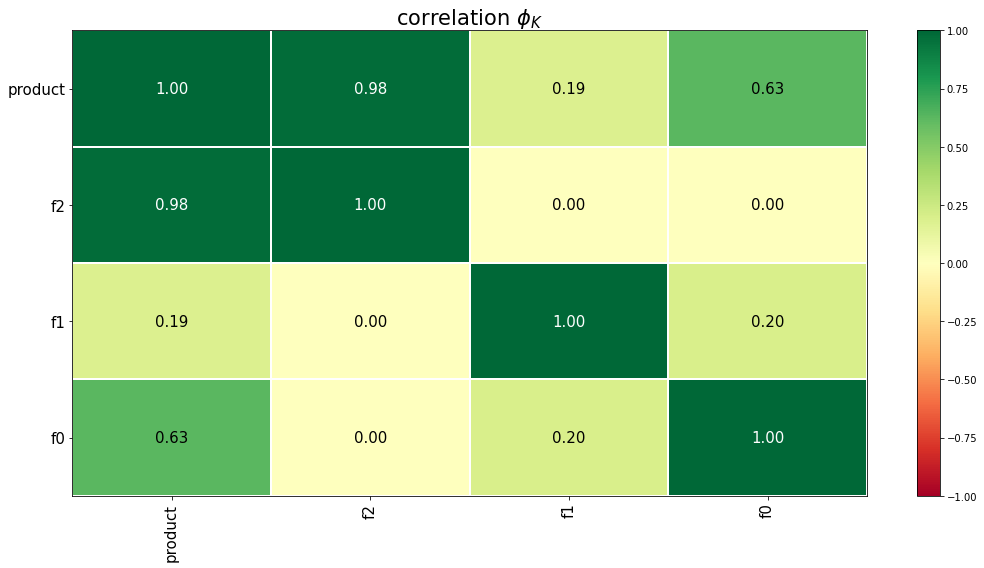

In [16]:
phik_overview = geo_data_1.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 8)
)

### geo_data_2

In [17]:
geo_data_2.info()
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [18]:
geo_data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [19]:
print(geo_data_2.duplicated().sum(), geo_data_2.drop('id', axis=1).duplicated().sum())

0 0


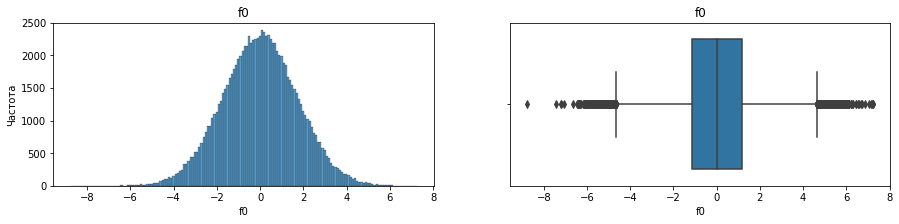

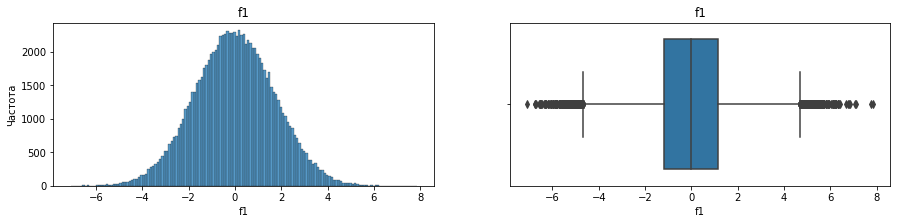

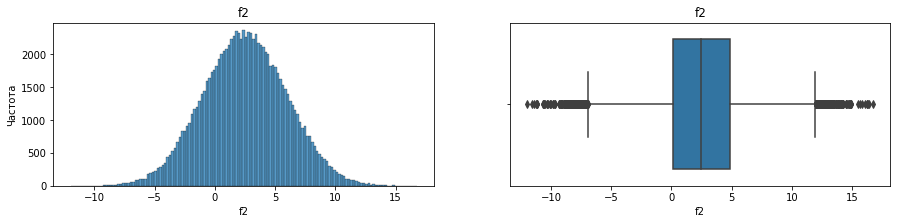

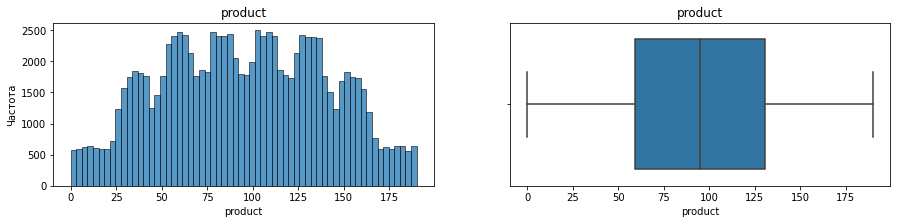

In [20]:
for col in col_features:
    plot_col(geo_data_2, col)

In [21]:
for i in col_features:
    stat, p_val = kstest(geo_data_2[i], "norm")
    if p_val < 0.05: 
        print(f'Распределение {i} не нормальное')
    else: 
        print(f'Распределение {i} нормальное')

Распределение f0 не нормальное
Распределение f1 не нормальное
Распределение f2 не нормальное
Распределение product не нормальное


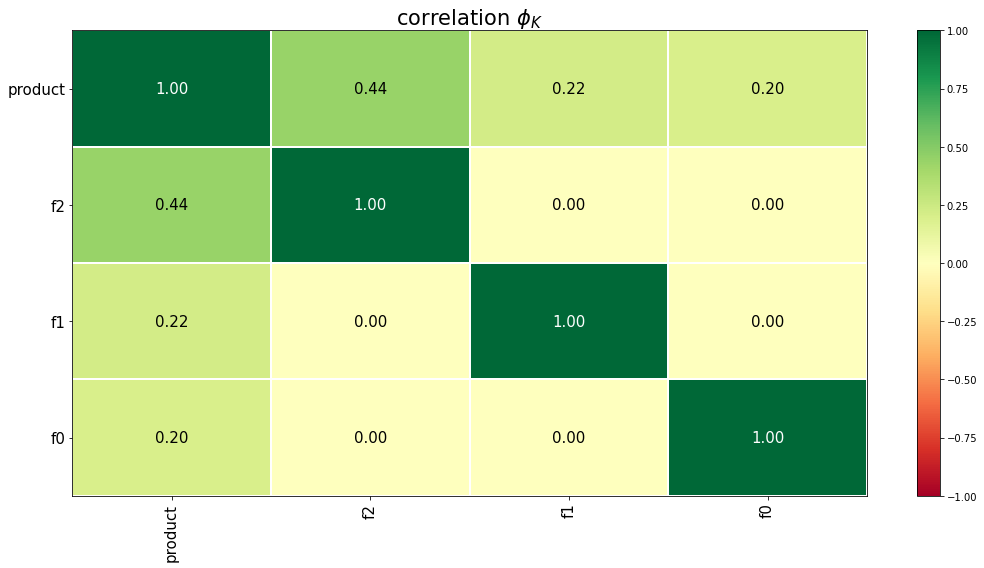

In [22]:
phik_overview = geo_data_2.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 8)
)

### Итог
- Данные загружены и проверены на соответствие типов
- Дубликаты отсутствуют
- Пропуски отсутствуют
- Явные выбросы отсутствуют
- Признаки проверены на нормальность тестом Колмагорова-Смирнова. Распределение признаков не соответствует нормальному
- Сильная взаимосвязь присутствует в данных 2 региона между f2 и product - 0.98. В остальных данных мультиколлинеарность отсутствует

<a id='section2'></a>
## Обучение и проверка модели

In [23]:
def model_learning(df):
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.25)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return rmse, y_valid, y_pred

In [24]:
rmse_0, product_valid_0, product_pred_0 = model_learning(geo_data_0)
rmse_1, product_valid_1, product_pred_1 = model_learning(geo_data_1)
rmse_2, product_valid_2, product_pred_2 = model_learning(geo_data_2)

In [25]:
result = pd.DataFrame(index=['Средний запас валидационного сырья', 'Средний запас предсказанного сырья', 'RMSE'], 
                      columns=['1 регион', '2 регион', '3 регион'])

result['1 регион'] = [np.mean(product_valid_0), np.mean(product_pred_0), rmse_0]
result['2 регион'] = [np.mean(product_valid_1), np.mean(product_pred_1), rmse_1]
result['3 регион'] = [np.mean(product_valid_2), np.mean(product_pred_2), rmse_2]
result

,1 регион,2 регион,3 регион
Средний запас валидационного сырья,92.325956,68.725381,95.150999
Средний запас предсказанного сырья,92.398800,68.712878,94.771024
RMSE,37.756600,0.890280,40.145872


### Итог
- Целевой признак предсказан с помощью Линейной регрессии
- Качество моделей оценивалось с помощью RMSE
- Лучший результат пренадлежит модели построенной по 2 региону - модель в среднем ошибалась лишь на 0.89
- Значения метрик для 1 и 3 регионов примерно одинаковые - 37.8 и 40.1 соответственно
- Средние по истинным и предсказанным значениям примерно одинаковые
- По предсказанным данным в 3 регионе среднедобываемый объем нефти наивысший - 94.7 тыс.баррелей. В 1 регионе показатели немного отстают - 92.4 тыс.баррелей. Во 2 регионе средний запас сырья сильно ниже - 68.7 тыс.баррелей.

<a id='section3'></a>
## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. <br>
Бюджет на разработку скважин в регионе — 10 млрд рублей. <br>
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. <br>
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [26]:
TOTAL_PLACES = 500 # штук
BEST_PLACES = 200  # штук
BUDGET = 1e+7 # Тысяч рублей
INCOME_PER_ONE = 450 # Тысяч рублей
LOSS_PROB = 0.025 # Доля

In [27]:
avg_budget = BUDGET / BEST_PLACES
print(f'Минимальный бюджет 1 месторождения: {avg_budget} тыс. руб.')

avg_oil = avg_budget / INCOME_PER_ONE
print(f'Минимальный объем нефти 1 месторождения: {round(avg_oil, 1)} тыс. баррелей')

Минимальный бюджет 1 месторождения: 50000.0 тыс. руб.
Минимальный объем нефти 1 месторождения: 111.1 тыс. баррелей


In [28]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return INCOME_PER_ONE * selected.sum() - BUDGET

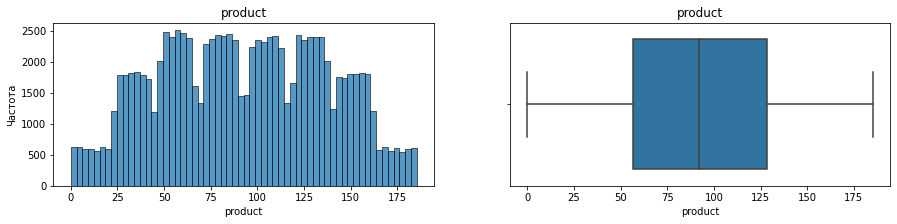

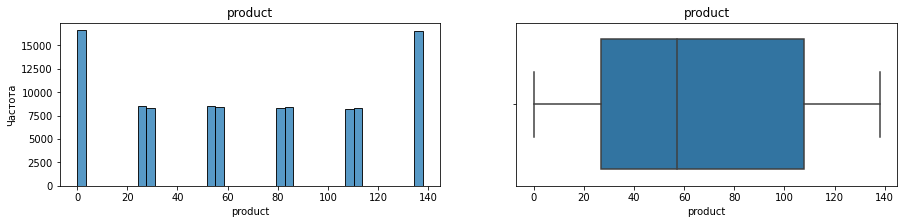

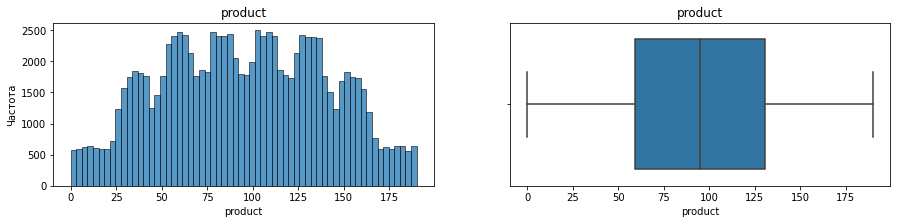

In [29]:
plot_col(geo_data_0, 'product')
plot_col(geo_data_1, 'product')
plot_col(geo_data_2, 'product')

In [33]:
data = {'Средний объём добываемой нефти, тыс.баррелей': \
        [geo_data_0['product'].mean(), geo_data_1['product'].mean(), geo_data_2['product'].mean()]}
pd.DataFrame(data, index=['1 регион', '2 регион', '3 регион'], columns=['Средний объём добываемой нефти, тыс.баррелей'])

,"Средний объём добываемой нефти, тыс.баррелей"
1 регион,92.500
2 регион,68.825
3 регион,95.000


### Итог
- Построена оценка на минимальный бюджет 1 месторождения - 50000 тыс.руб.
- Постороена оценка на минимальный объем нефти, добываемой на 1 месторождении - 111.1 тыс. баррелей
- В 1 и 3 регионах выше среднее значение добываеомого объема нефти по регионы, следовательно, вероятность покрыть расходы выше
- Важно отметить, что средний объем добываемой нефти в регионах составляет 92.5, 68.8, 95.0 тыс.баррелей соответственно, в то время как минимальный среднедобываемый объем для безубыточной торговли должен быть 111.1 тыс.баррелей 

<a id='section4'></a>
## Расчёт прибыли и рисков 

In [31]:
state = np.random.RandomState(12345)

def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=TOTAL_PLACES)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, BEST_PLACES)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000 * 100
    
    return average, lower, upper, risk

In [32]:
data = {'product' : product_valid_0, 'pred_product' : product_pred_0}
res_0 = pd.DataFrame(data, columns = ['product', 'pred_product'])
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(res_0['product'], res_0['pred_product'])

data = {'product' : product_valid_1, 'pred_product' : product_pred_1}
res_1 = pd.DataFrame(data, columns = ['product', 'pred_product'])
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(res_1['product'], res_1['pred_product'])

data = {'product' : product_valid_2, 'pred_product' : product_pred_2}
res_2 = pd.DataFrame(data, columns = ['product', 'pred_product'])
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(res_2['product'], res_2['pred_product'])

data = {'Средняя прибыль по региону, тыс.руб.': [round(average_0, 2), round(average_1, 2), round(average_2, 2)], 
        'Риск, %': [risk_0, risk_1, risk_2],
        '95% доверительный интервал': [(round(lower_0, 2), round(upper_0, 2)), 
                                      (round(lower_1, 2), round(upper_1, 2)), 
                                      (round(lower_2, 2), round(upper_2, 2))]}
pd.DataFrame(data, index=['1 регион', '2 регион', '3 регион'],
             columns=['Средняя прибыль по региону, тыс.руб.', 'Риск, %', '95% доверительный интервал'])

,"Средняя прибыль по региону, тыс.руб.","Риск, %",95% доверительный интервал
1 регион,406278.78,6.7,"(-117742.14, 911737.05)"
2 регион,441504.28,1.6,"(35728.49, 828006.64)"
3 регион,385213.20,7.8,"(-164785.17, 888206.23)"


### Итог:
- С помощью бутстрап были построены оценки для средней прибыли по региону, расчитаны риски и найдены 95% доверительные интервалы
- 2 регион является лидером по результатам, так как:
    - Имеет наименьший процент рисков
    - Весь доверительный интервал находится в положительной части возможных значений, что увеличивает вероятность принятия положительного значения для средней прибыли по региону
    - Оценка среднего значения прибыли по 2 региону является максимальной из трёх

<a id='section5'></a>
## Общий вывод
- Загрузка и подготовка данных:
    - Данные загружены и проверены на соответствие типов
    - Дубликаты отсутствуют
    - Пропуски отсутствуют
    - Явные выбросы отсутствуют
    - Признаки проверены на нормальность тестом Колмагорова-Смирнова. Распределение признаков не соответствует нормальному
    - Мультиколлинеарность отсутствует
- Обучение и проверка модели:
    - Целевой признак предсказан с помощью Линейной регрессии
    - Качество моделей оценивалось с помощью RMSE
    - Лучший результат пренадлежит модели построенной по 2 региону - модель в среднем ошибалась лишь на 0.89
    - Значения метрик для 1 и 3 регионов примерно одинаковые - 37.8 и 40.1 соответственно
    - Средние по истинным и предсказанным значениям примерно одинаковые
- Подготовка к расчету прибыли:
    - Построена оценка на минимальный бюджет 1 месторождения - 50000 тыс.руб.
    - Постороена оценка на минимальный объем нефти, добываемой на 1 месторождении - 111.1 тыс. баррелей
    - В 1 и 3 регионах выше среднее значение добываеомого объема нефти по регионы, следовательно, вероятность покрыть расходы выше
- Расчет прибыли и рисков:
    - С помощью бутстрап были построены оценки для средней прибыли по региону, расчитаны риски и найдены 95% доверительные интервалы
    - 2 регион является лидером по результатам, так как:
        - Имеет наименьший процент рисков
        - Весь доверительный интервал находится в положительной части возможных значений, что увеличивает вероятность принятия положительного значения для средней прибыли по региону
        - Оценка среднего значения прибыли по 2 региону является максимальной из трёх